Install required packages

In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 18.6 MB/s eta 0:00:00


Import libraries

In [2]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display

from tensorflow.keras.applications import InceptionV3

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

%matplotlib inline

Define the paths for training and validation directories

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = "/content/drive/MyDrive/fitur1_deploy_InceptionV3/Dataset/training"
val_dir = "/content/drive/MyDrive/fitur1_deploy_InceptionV3/Dataset/validation"

Train and Validation Data Generators Creation with Image Augmentation

In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size for better performance
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size for better performance
    class_mode='categorical')

Found 2400 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


Load the InceptionV3 model

In [6]:
# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Set all layers in the InceptionV3 model to be non-trainable
for layer in inception_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


Building Classification Model of InceptionV3

In [7]:
model = Sequential()
model.add(inception_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

Model Compilation and Callback Initialization

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.9:
            print("\nReached desired accuracy! Training stopped.")
            self.model.stop_training = True

callbacks = myCallback()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

Training Model

In [9]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
75/75 [==============================] - 729s 10s/step - loss: 0.9700 - accuracy: 0.6971 - val_loss: 0.3934 - val_accuracy: 0.8792
Epoch 2/50
75/75 [==============================] - 198s 3s/step - loss: 0.4747 - accuracy: 0.8392 - val_loss: 0.4011 - val_accuracy: 0.8500
Epoch 3/50
75/75 [==============================] - 196s 3s/step - loss: 0.4054 - accuracy: 0.8708 - val_loss: 0.3029 - val_accuracy: 0.8975
Epoch 4/50
75/75 [==============================] - 199s 3s/step - loss: 0.3621 - accuracy: 0.8683 - val_loss: 0.4858 - val_accuracy: 0.8317
Epoch 5/50
75/75 [==============================] - 195s 3s/step - loss: 0.3110 - accuracy: 0.8933 - val_loss: 0.3497 - val_accuracy: 0.8783
Epoch 6/50
75/75 [==============================] - 197s 3s/step - loss: 0.3137 - accuracy: 0.8979 - val_loss: 0.4080 - val_accuracy: 0.8642
Epoch 7/50
75/75 [==============================] - 170s 2s/step - loss: 0.2899 - accuracy: 0.9008 - val_loss: 0.4588 - val_accuracy: 0.8625
Epoch 8/50
7

Display the training accuracy plot

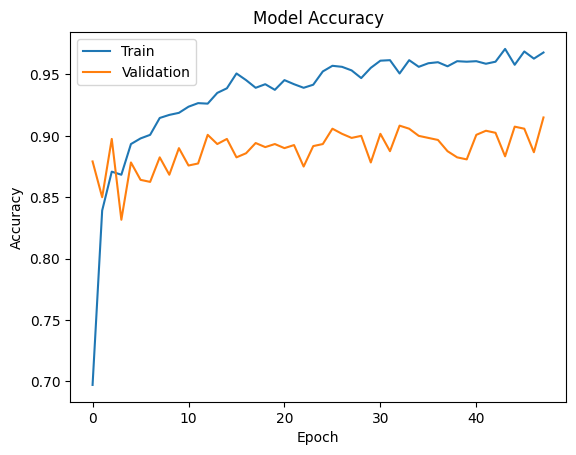

In [10]:
# Menampilkan plot akurasi pelatihan
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Display the training loss plot

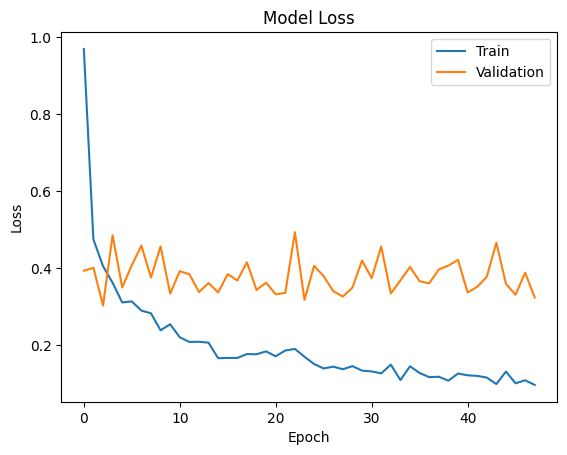

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test Model

1/1 [==============================] - 0s 69ms/step


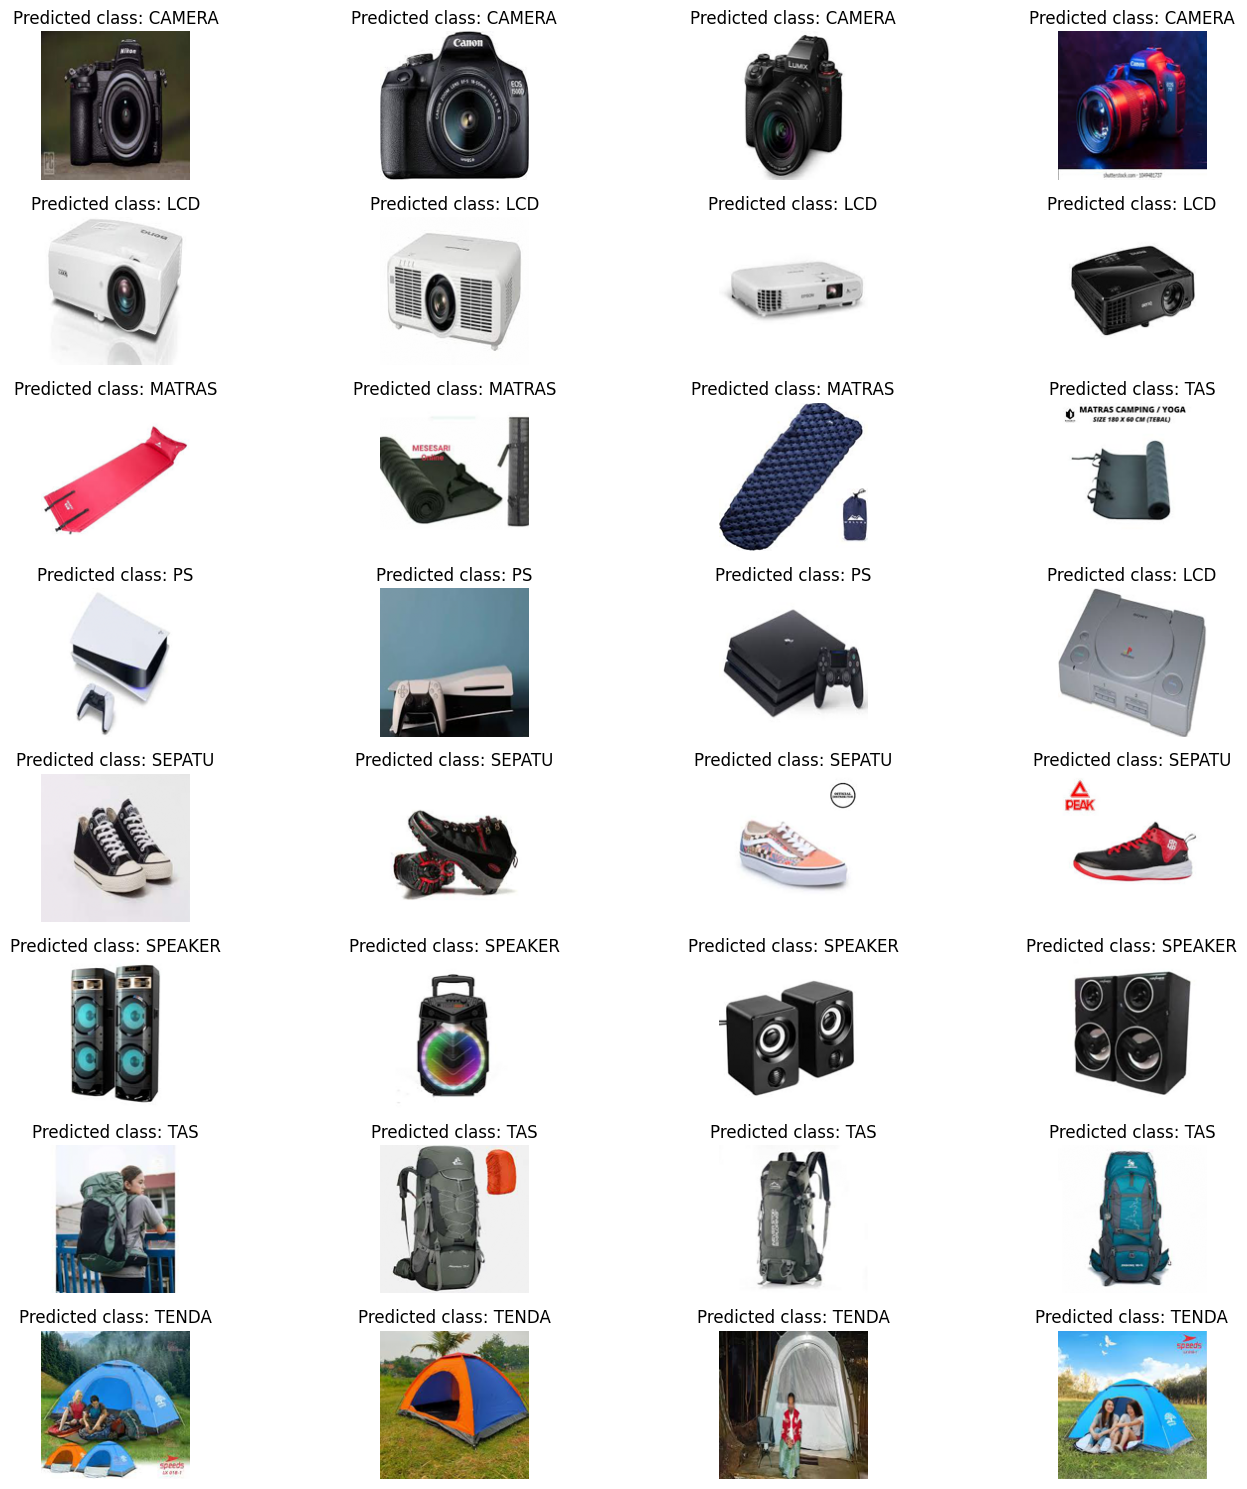

In [12]:
import os
import matplotlib.pyplot as plt

# Path ke folder yang berisi gambar-gambar yang ingin diuji
folder_path = "/content/drive/MyDrive/fitur1_deploy_InceptionV3/Dataset/tes_data"

# Daftar file gambar dalam folder
image_files = os.listdir(folder_path)

# Menghitung jumlah gambar
num_images = len(image_files)

# Mengatur jumlah kolom dalam subplot
num_cols = 4

# Menghitung jumlah baris dalam subplot
num_rows = (num_images + num_cols - 1) // num_cols

# Membuat subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Perulangan untuk setiap file gambar
for i, file in enumerate(image_files):
    # Memuat gambar
    image_path = os.path.join(folder_path, file)
    test_image = Image.open(image_path)
    test_image = test_image.resize((150, 150))  # Menyesuaikan ukuran gambar dengan ukuran input model
    test_image = np.array(test_image) / 255.0  # Normalisasi piksel gambar

    # Menambahkan dimensi batch pada gambar
    test_image = np.expand_dims(test_image, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = model.predict(test_image)

    # Mendapatkan kelas prediksi
    predicted_class = np.argmax(predictions)

    # Mengubah kelas prediksi menjadi label kelas
    class_labels = train_generator.class_indices
    predicted_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class)]

    # Menampilkan gambar dan hasil prediksi pada subplot yang sesuai
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(test_image[0])
    ax.axis('off')  # Menghilangkan sumbu koordinat
    ax.set_title('Predicted class: ' + predicted_label)

# Menampilkan subplot
plt.tight_layout()
plt.show()

SAVE_MODEL TFJS

In [13]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [14]:
# Save the trained model as a Keras HDF5 file. 

saved_model_path = "./my_model.h5"
model.save(saved_model_path)


In [15]:
# Use the tensorflow.js converter to convert the saved Keras model into JSON format.

!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-05-26 00:47:08.648406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
from google.colab import files

# Mendownload file model.json
files.download('/content/model.json')

# Mendownload file group-shard.bin
files.download('/content/group1-shard1of22.bin')
files.download('/content/group1-shard2of22.bin')
files.download('/content/group1-shard3of22.bin')
files.download('/content/group1-shard4of22.bin')
files.download('/content/group1-shard5of22.bin')
files.download('/content/group1-shard6of22.bin')
files.download('/content/group1-shard7of22.bin')
files.download('/content/group1-shard8of22.bin')
files.download('/content/group1-shard9of22.bin')
files.download('/content/group1-shard10of22.bin')
files.download('/content/group1-shard11of22.bin')
files.download('/content/group1-shard12of22.bin')
files.download('/content/group1-shard13of22.bin')
files.download('/content/group1-shard14of22.bin')
files.download('/content/group1-shard15of22.bin')
files.download('/content/group1-shard16of22.bin')
files.download('/content/group1-shard17of22.bin')
files.download('/content/group1-shard18of22.bin')
files.download('/content/group1-shard19of22.bin')
files.download('/content/group1-shard20of22.bin')
files.download('/content/group1-shard21of22.bin')
files.download('/content/group1-shard22of22.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>